## Some notes w.r.t. the PCA cutting


In [1]:
# Importing a number of different tools
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')
import pandas
from pystain import StainDataset
import scipy as sp

# Start code
subject_id = 13095
ds = StainDataset(subject_id)

conversion_matrix = np.array([[0, 0, ds.xy_resolution],
                              [-ds.z_resolution, 0, 0],
                              [0, -ds.xy_resolution, 0]])
results = []

# What are the subject IDs?
subject_ids=[13095]#, 14037, 14051, 14069, 15033, 15035, 15055]

# how many sub-sections along each axis? 2, 3, 4, ...
n_sectors_per_axis = 10

# labels of sectors (this is ugly - sorry)
axis_labels = {'pma': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'vmd': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)]),
               'mml': np.array([float(x)/n_sectors_per_axis for x in np.arange(n_sectors_per_axis)])}

# # Define mid-point along each axis as origin (0,0,0)
for axis, sectors in axis_labels.items():
    axis_labels[axis] = sectors - sectors.mean()
    axis_labels[axis] = [axis + '_' + str(x) for x in axis_labels[axis]]


# Unsmoothed data
for subject_id in subject_ids[:]:
    ds = StainDataset(subject_id)

    # Get coordinates of mask and bring them to mm
    x, y, z = np.where(ds.thresholded_mask)
    coords = np.column_stack((x, y, z))
    coords_mm = conversion_matrix.dot(coords.T).T
    coords_mm -= coords_mm.mean(0)

    # Fit two components and make sure first axis walks dorsal
    #   and second component lateral
    pca = PCA()
    pca.fit_transform((coords_mm - coords_mm.mean(0))[:, (0, 2)])

    components = pca.components_
    print(components)

    if components[0, 1] < 0:
        components[0] = -components[0]

    if components[1, 0] < 0:
        components[1] = -components[1]

    print(components)

    # principal components
    coords_dataframe = pandas.DataFrame(coords_mm, columns=['x_mm', 'y_mm', 'z_mm'])
    coords_dataframe['slice'] = x

    coords_dataframe['pc1'] = components.dot(coords_mm[:, (0, 2)].T)[0, :]
    coords_dataframe['pc2'] = components.dot(coords_mm[:, (0, 2)].T)[1, :]

    coords_dataframe[['pc1_slice_center', 'pc2_slice_center']] = coords_dataframe.groupby(['slice'])[['pc1', 'pc2']].apply(lambda x: x - x.mean())

    # cut along axes
    axis_labels_pma = np.array([float(y)/n_sectors_per_axis for y in np.arange(np.unique(x).shape[0])])
#     coords_dataframe['slice_sector'] = pandas.qcut(coords_dataframe.y_mm, n_sectors_per_axis, labels=axis_labels['pma'])
    coords_dataframe['slice_sector'] = x
    
#     coords_dataframe['slice_sector_coordinate'] = (x-np.mean(x))/np.max(x)
    coords_dataframe['pc1_sector'] = coords_dataframe.groupby('slice_sector').pc1.apply(lambda d: pandas.qcut(d, n_sectors_per_axis))#, labels=axis_labels['vmd']))
    coords_dataframe['pc2_sector'] = coords_dataframe.groupby('slice_sector').pc2.apply(lambda d: pandas.qcut(d, n_sectors_per_axis))#, labels=axis_labels['mml']))
#     coords_dataframe['pc1_type2'] = pd.cut(coords_dataframe['pc1'], 20)
#     coords_dataframe['pc2_type2'] = pd.cut(coords_dataframe['pc2'], 20)

    df = pandas.concat((ds.dataframe, coords_dataframe), 1)
    df['n_voxels'] = 1
    # This is count data, so sum (NB: I later divide the sum by the number of voxels - so you might as well take the mean immediately)
    tmp = df.pivot_table(index=['pc1_sector', 'pc2_sector', 'slice_sector'], values=ds.stains + ['n_voxels', 'x_mm', 'y_mm', 'z_mm'], aggfunc='sum').copy()
    tmp['subject_id'] = subject_id

    results.append(tmp.copy())
    break

# df = pandas.concat(results).reset_index().set_index(['subject_id', 'slice_sector', 'pc1_sector', 'pc2_sector', 'n_voxels'])
# df = pandas.melt(df.reset_index(), id_vars=['subject_id', 'slice_sector', 'pc1_sector', 'pc2_sector', 'n_voxels'], var_name='stain')
# df['rate'] = df['value'] / df['n_voxels']  # rate is the main dependent variable of interest
# df['rate_normalized'] = df.groupby(['subject_id', 'stain'])['rate'].apply(lambda x: (x - x.mean()) / x.std())

# # add coordinates of individual sectors along axis as float (easier later on)
# #df['slice_sector_coordinate'] = pandas.to_numeric(df['slice_sector'].apply(lambda x: float(x.split('_')[1])))
# df['pc1_sector_coordinate'] = pandas.to_numeric(df['pc1_sector'].apply(lambda x: float(x.split('_')[1])))
# df['pc2_sector_coordinate'] = pandas.to_numeric(df['pc2_sector'].apply(lambda x: float(x.split('_')[1])))

/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
/home/stevenm/data/post_mortem/new_data_format/13095/images.hdf5
[[-0.98094749 -0.19427308]
 [-0.19427308  0.98094749]]
[[ 0.98094749  0.19427308]
 [ 0.19427308 -0.98094749]]


In [2]:
df.head()

,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,...,z_mm,slice,pc1,pc2,pc1_slice_center,pc2_slice_center,slice_sector,pc1_sector,pc2_sector,n_voxels
0,1.0,0.0,55.0,0.0,53.0,0.0,0.0,4.0,1.0,4.0,...,2.642762,1,-1.708955,-3.032543,0.634359,-1.872113,1,"(-1.847, -1.575]","(-3.034, -2.307]",1
1,1.0,1.0,30.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,...,2.628670,1,-1.739339,-3.024195,0.603975,-1.863765,1,"(-1.847, -1.575]","(-3.034, -2.307]",1
2,0.0,1.0,27.0,25.0,26.0,0.0,0.0,0.0,18.0,14.0,...,2.614578,1,-1.686783,-2.999421,0.656531,-1.838991,1,"(-1.847, -1.575]","(-3.034, -2.307]",1
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,...,2.600486,1,-1.730991,-2.993811,0.612323,-1.833380,1,"(-1.847, -1.575]","(-3.034, -2.307]",1
4,6.0,1.0,2.0,0.0,59.0,0.0,6.0,4.0,0.0,2.0,...,2.600486,1,-1.689521,-2.985598,0.653793,-1.825167,1,"(-1.847, -1.575]","(-3.034, -2.307]",1


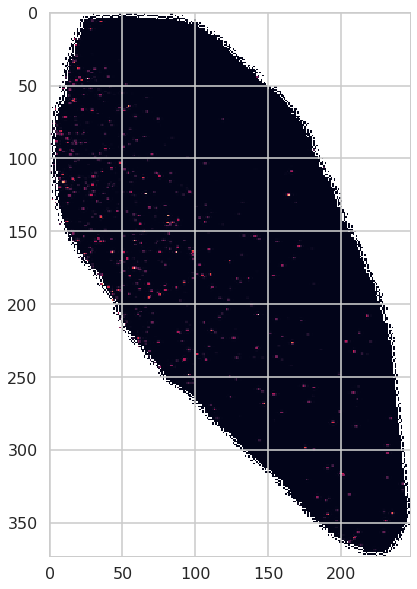

In [5]:
flat = df.loc[df.slice==df.slice.unique()[3]].pivot_table(index='z_mm', columns='x_mm', values=['TH'], aggfunc=np.nanmean)
plt.imshow(flat)
plt.gcf().set_size_inches(10,10)

### What do the PCA axes look like in 3D?

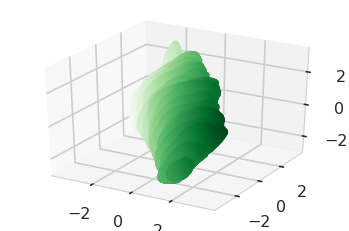

In [24]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(coords_dataframe['x_mm'], coords_dataframe['y_mm'], coords_dataframe['z_mm'], c=coords_dataframe['pc1'], cmap='Greens');

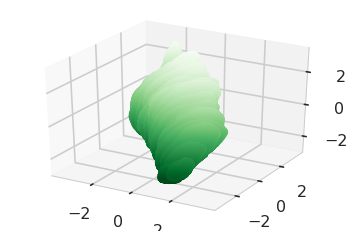

In [25]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(coords_dataframe['x_mm'], coords_dataframe['y_mm'], coords_dataframe['z_mm'], c=coords_dataframe['pc2'], cmap='Greens');

and how is CALR distributed for this sub?

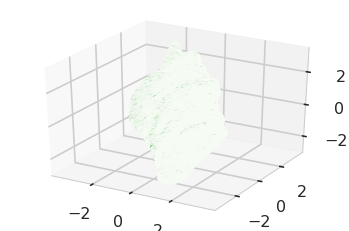

In [23]:
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(df['x_mm'], df['y_mm'], df['z_mm'], c=df['CALR'], cmap='Greens');

### PC1 axis in 2D (first slice)

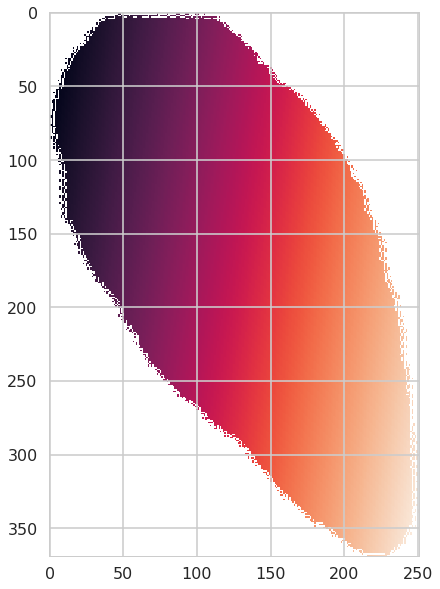

In [6]:
flat = df.loc[df.slice==df.slice.unique()[4]].pivot_table(index='z_mm', columns='x_mm', values=['pc1'], aggfunc=np.nanmean)
plt.imshow(flat)
plt.gcf().set_size_inches(10,10)

In [13]:
# vmd_labels = ['vmd_' + str(x) for x in np.arange(20)]
# mml_labels = ['mml_' + str(x) for x in np.arange(20)]
n_cuts = 12
vmd_labels = np.arange(n_cuts)
mml_labels = np.arange(n_cuts)

df['pc1_qcut'] = df.groupby('slice')['pc1'].apply(lambda d: pandas.qcut(d, n_cuts, vmd_labels))
df['pc2_qcut'] = df.groupby(['slice', 'pc1_qcut']).pc2.apply(lambda d: pandas.qcut(d, n_cuts, mml_labels))

df['pc1_cut'] = df.groupby('slice')['pc1'].apply(lambda d: pandas.cut(d, n_cuts, labels=vmd_labels))
df['pc2_cut'] = df.groupby(['slice', 'pc1_cut']).pc2.apply(lambda d: pandas.cut(d, n_cuts, labels=mml_labels))

df['pc2_cut2'] = df.groupby(['slice']).pc2.apply(lambda d: pandas.cut(d, n_cuts, labels=mml_labels))
df['pc2_qcut2'] = df.groupby(['slice']).pc2.apply(lambda d: pandas.qcut(d, n_cuts, labels=mml_labels))


In [8]:
df['pc1_qcut_mm'] = df['pc1_qcut'].apply(lambda x: x.mid)
df['pc2_qcut_mm'] = df['pc2_qcut'].apply(lambda x: x.mid)

In [15]:
df.groupby('pc1_qcut_mm').pc2_qcut_mm.min().head()

pc1_qcut_mm
-3.4665   -0.2515
-3.3145   -0.5280
-3.2635   -0.3497
-3.1365   -0.8405
-3.0865   -0.3860
Name: pc2_qcut_mm, dtype: float64

In [14]:
df.head()

,CALR,FER,GABRA3,GAD6567,MBP,PARV,SERT,SMI32,SYN,TH,...,pc2_sector,n_voxels,pc1_qcut,pc2_qcut,pc1_cut,pc2_cut,pc2_cut2,pc2_qcut2,pc1_qcut_mm,pc2_qcut_mm
0,1.0,0.0,55.0,0.0,53.0,0.0,0.0,4.0,1.0,4.0,...,"(-3.034, -2.307]",1,11,0,11,0,0,0,-1.699,-2.9365
1,1.0,1.0,30.0,0.0,14.0,0.0,0.0,0.0,0.0,1.0,...,"(-3.034, -2.307]",1,11,0,10,0,0,0,-1.699,-2.9365
2,0.0,1.0,27.0,25.0,26.0,0.0,0.0,0.0,18.0,14.0,...,"(-3.034, -2.307]",1,11,0,11,0,0,0,-1.699,-2.9365
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,...,"(-3.034, -2.307]",1,11,0,10,0,0,0,-1.699,-2.9365
4,6.0,1.0,2.0,0.0,59.0,0.0,6.0,4.0,0.0,2.0,...,"(-3.034, -2.307]",1,11,0,11,0,0,0,-1.699,-2.9365


In [16]:
df['pc1_qcut'] = pandas.to_numeric(df['pc1_qcut'])
df['pc1_cut'] = pandas.to_numeric(df['pc1_cut'])
df['pc2_qcut'] = pandas.to_numeric(df['pc2_qcut'])
df['pc2_cut'] = pandas.to_numeric(df['pc2_cut'])

df['pc2_qcut2'] = pandas.to_numeric(df['pc2_qcut2'])
df['pc2_cut2'] = pandas.to_numeric(df['pc2_cut2'])

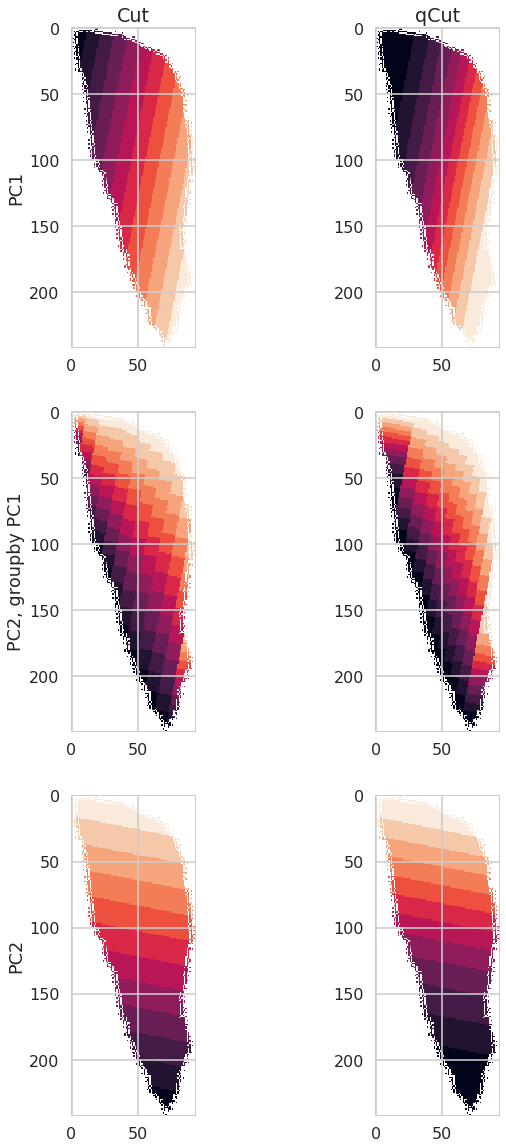

In [18]:
f, ax = plt.subplots(3,2)
flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc1_cut'], aggfunc=np.nanmean)
ax[0,0].imshow(flat)
ax[0,0].set_title('Cut')
flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc1_qcut'], aggfunc=np.nanmean)
ax[0,1].imshow(flat)
ax[0,1].set_title('qCut')
ax[0,0].set_ylabel('PC1')

flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc2_cut'], aggfunc=np.nanmean)
ax[1,0].imshow(flat)
ax[1,0].set_ylabel('PC2, groupby PC1')
flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc2_qcut'], aggfunc=np.nanmean)
ax[1,1].imshow(flat)

flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc2_cut2'], aggfunc=np.nanmean)
ax[2,0].imshow(flat)
ax[2,0].set_ylabel('PC2')
flat = df.loc[df.slice==1].pivot_table(index='z_mm', columns='x_mm', values=['pc2_qcut2'], aggfunc=np.nanmean)
ax[2,1].imshow(flat)
plt.gcf().set_size_inches(10,20)

**IMPORTANT**
- In the cut-case, voxels (within each slice) are equally large (in mm)
- In the qcut-case, voxels (within each slice) contain an equal amount of original datapoint but have varying sizes
- In *BOTH* cases, voxel size differs per slice

qcut is easiest for plotting; since essentially this morphs each slice into a square, that allows for easy comparison across specimen. However, it is then important to keep in mind that each *voxel location* is *NOT* a linear function of the voxel *number*. That is, the *voxel location* (on the PC1/PC2 axes) needs to be kept track of separately, and needs to be used for modelling.

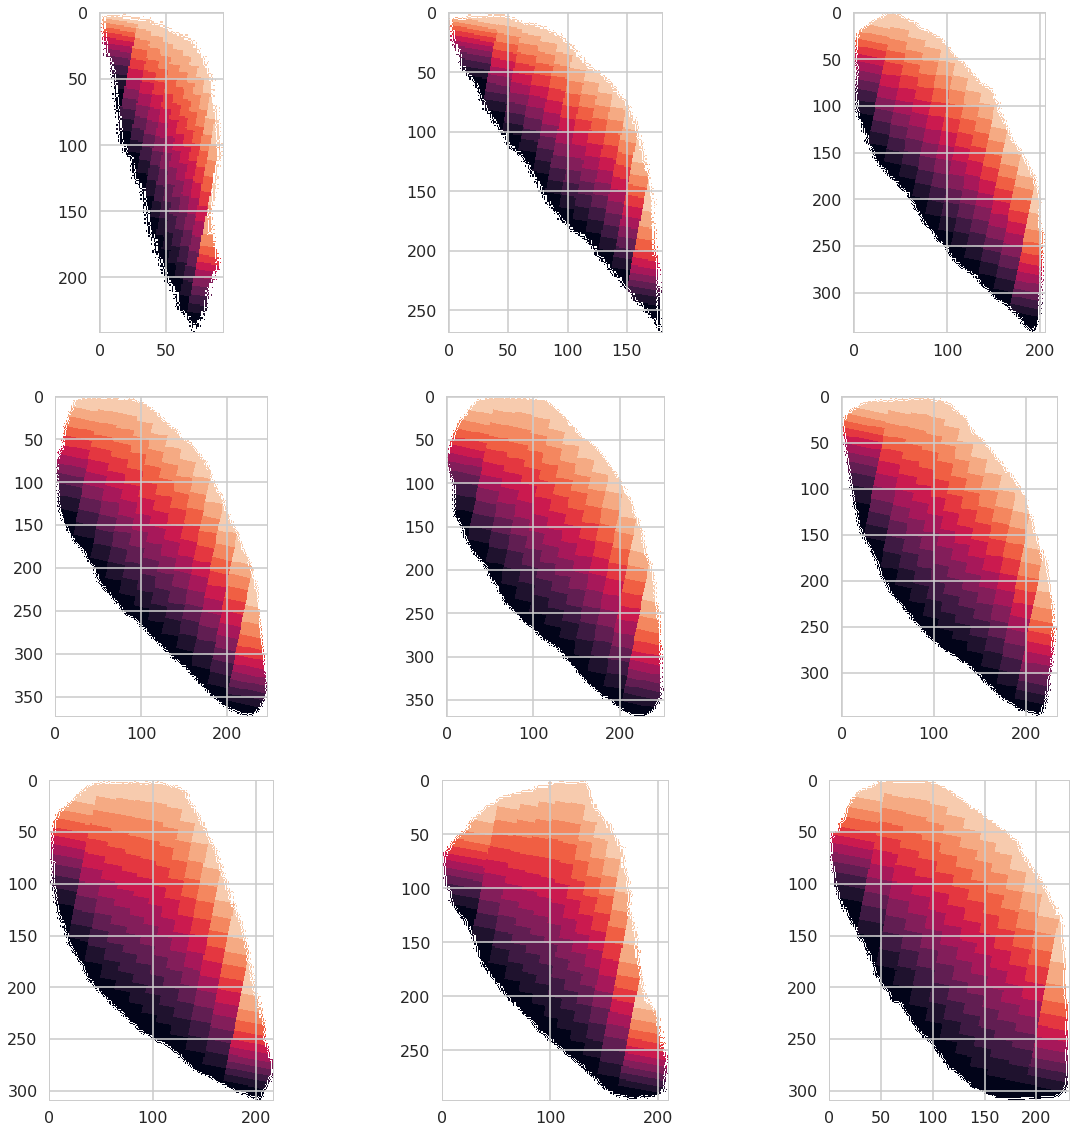

In [144]:
f, ax = plt.subplots(3,3)
ax = ax.ravel()
for i in range(9):
    flat = df.loc[df.slice==df.slice.unique()[i]].pivot_table(index='z_mm', columns='x_mm', values=['pc2_qcut'], aggfunc=np.nanmean)
    ax[i].imshow(flat, vmin=0, vmax=n_cuts)
plt.gcf().set_size_inches(20,20)

In [112]:
df_full = df.copy()

In [110]:
df = df_full.copy()

In [111]:
tmp = df.groupby(['slice', 'pc1_cut', 'pc2_cut'])['CALR'].mean().reset_index()
tmp.rename(columns={'CALR': 'CALR_cut'}, inplace=True)
df = pandas.merge(df, tmp, how='left')

tmp = df.groupby(['slice', 'pc1_qcut', 'pc2_qcut'])['CALR'].mean().reset_index()
tmp.rename(columns={'CALR': 'CALR_qcut'}, inplace=True)
df = pandas.merge(df, tmp, how='left')

In [108]:
idx = (df.pc1_cut == 0) | (df.pc1_cut == 19) | (df.pc2_cut == 0) | (df.pc2_cut == 19)
df = df.loc[~idx]

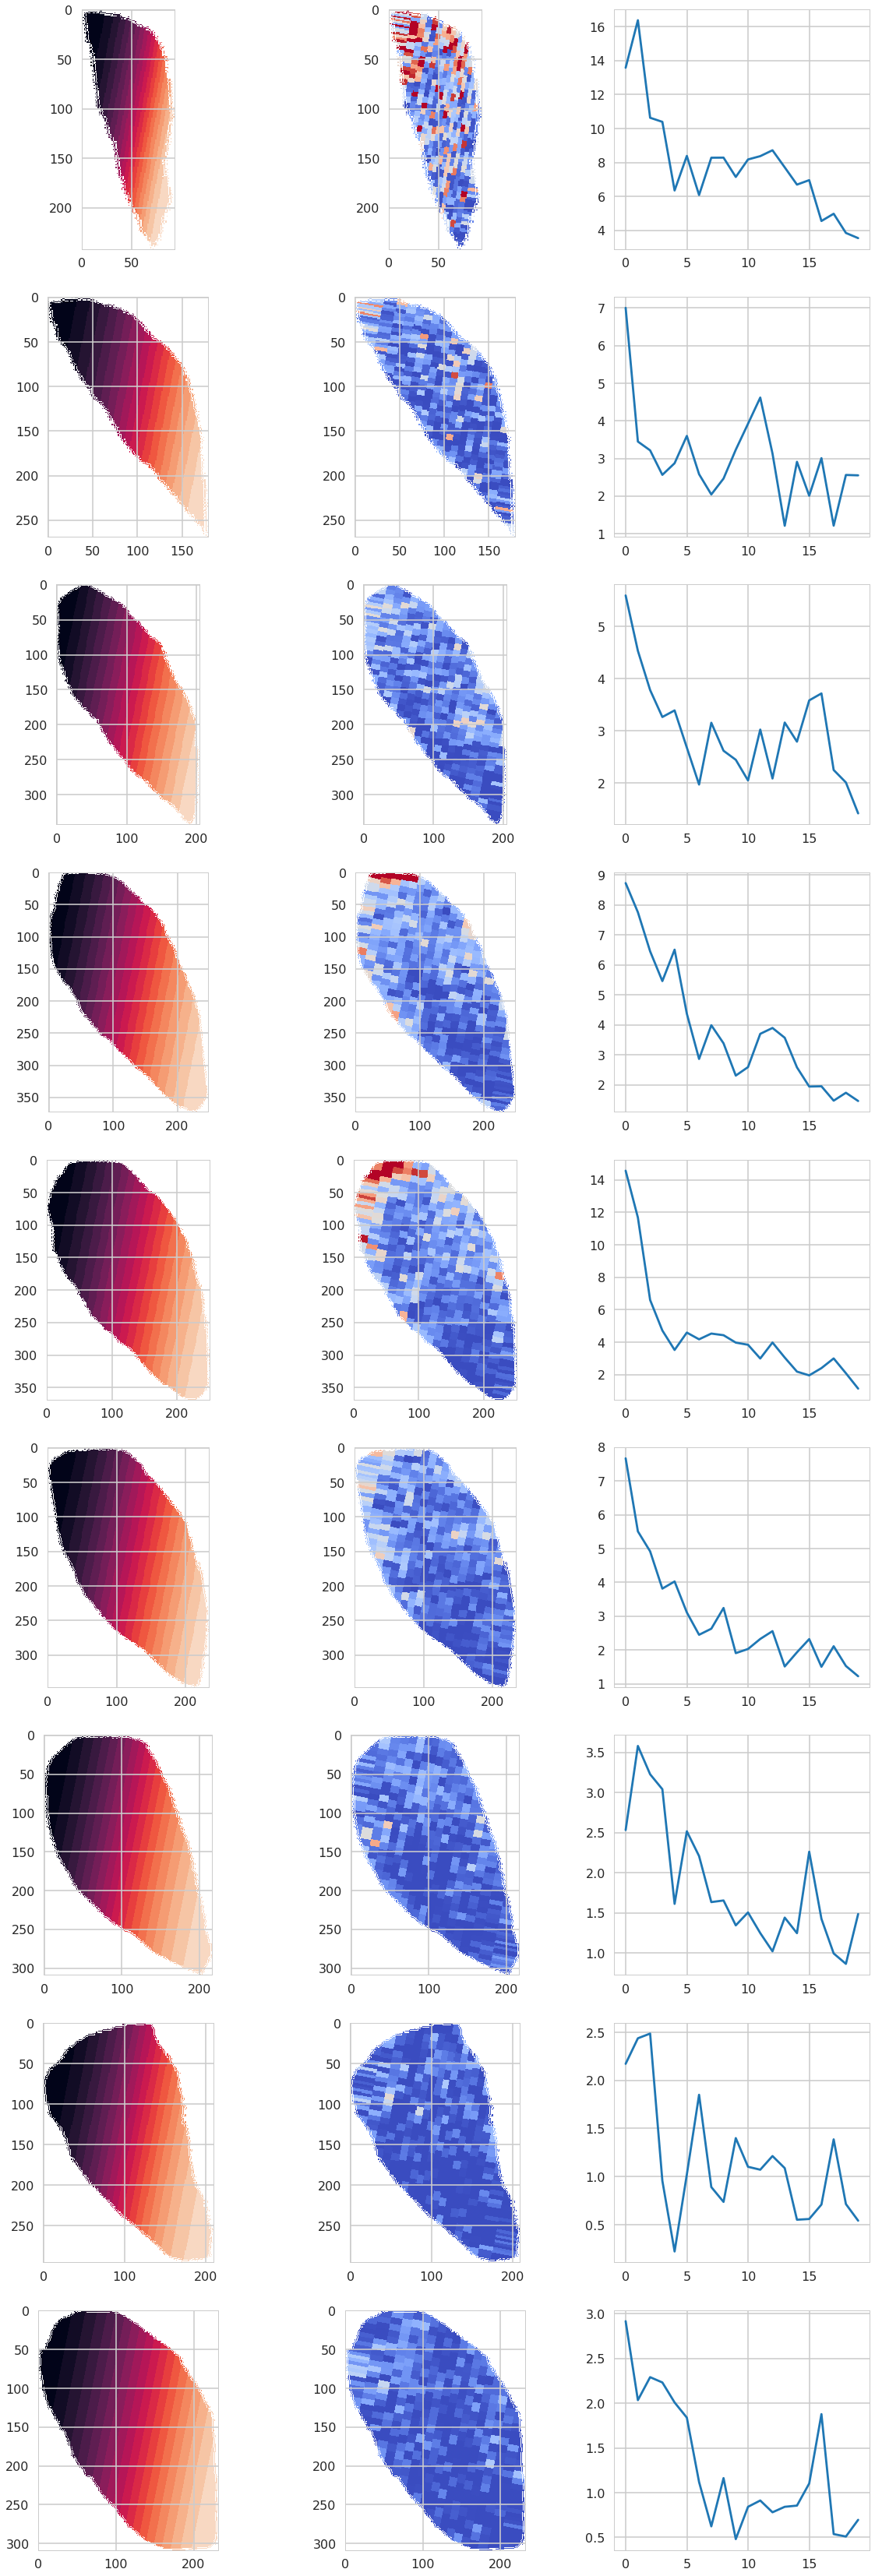

In [127]:
f, ax = plt.subplots(9,3)
#ax = ax.ravel()
for i in range(9):
    flat = df.loc[df.slice==df.slice.unique()[i]].pivot_table(index='z_mm', columns='x_mm', values=['pc1_qcut'], aggfunc=np.nanmean)
    ax[i,0].imshow(flat, vmin=0, vmax=n_cuts)
    flat = df.loc[df.slice==df.slice.unique()[i]].pivot_table(index='z_mm', columns='x_mm', values=['CALR_qcut'], aggfunc=np.nanmean)
    ax[i,1].imshow(flat, vmin=0, vmax=n_cuts, cmap=plt.cm.coolwarm)
    tmp = df.loc[df.slice==df.slice.unique()[i]].groupby('pc1_qcut')['CALR'].mean().reset_index()
#    tmp = tmp.sort_values(['pc1_cut'])
    ax[i,2].plot(tmp['pc1_qcut'], tmp['CALR'], '-')
plt.gcf().set_size_inches(20,20*3)

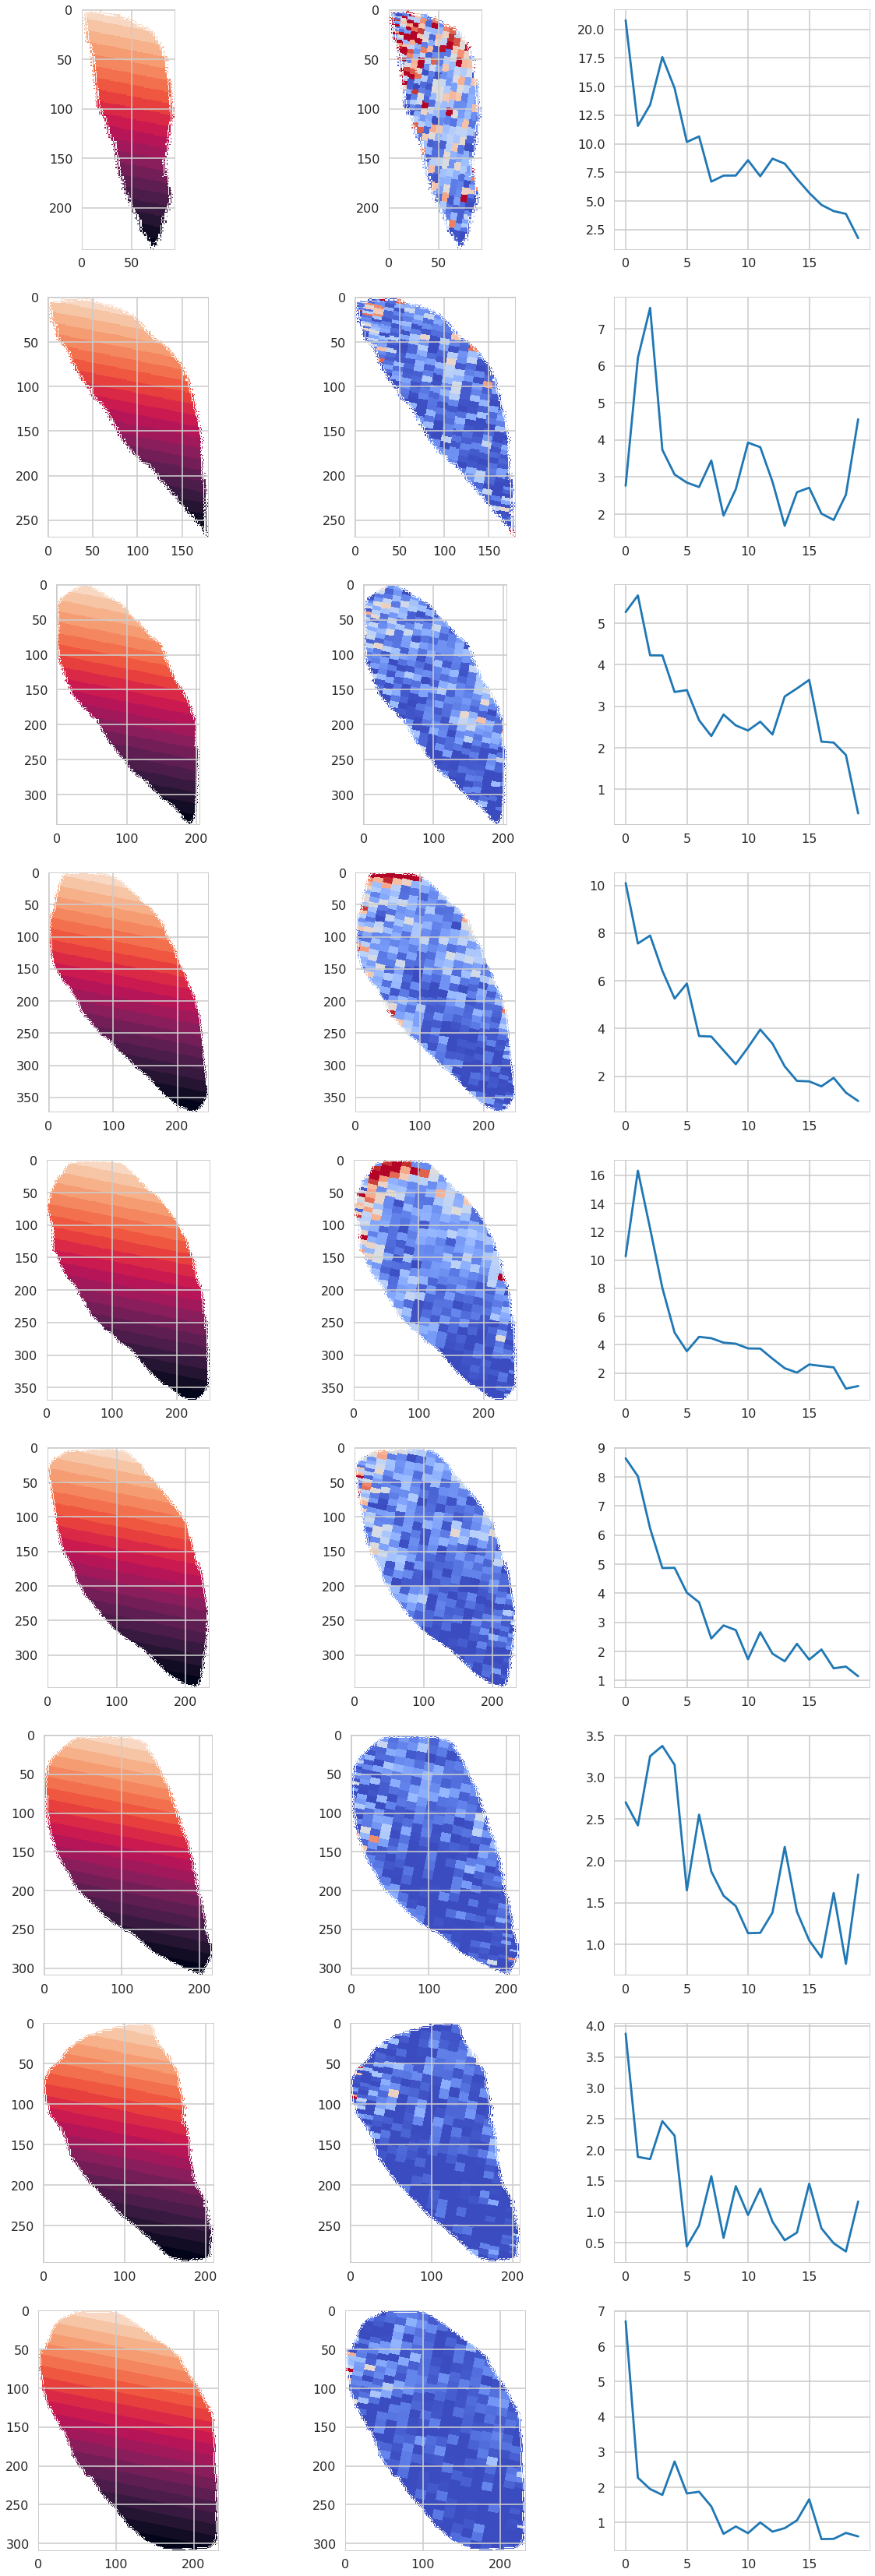

In [115]:
f, ax = plt.subplots(9,3)
#ax = ax.ravel()
for i in range(9):
    flat = df.loc[df.slice==df.slice.unique()[i]].pivot_table(index='z_mm', columns='x_mm', values=['pc2_cut2'], aggfunc=np.nanmean)
    ax[i,0].imshow(flat, vmin=0, vmax=n_cuts)
    flat = df.loc[df.slice==df.slice.unique()[i]].pivot_table(index='z_mm', columns='x_mm', values=['CALR_cut'], aggfunc=np.nanmean)
    ax[i,1].imshow(flat, vmin=0, vmax=n_cuts, cmap=plt.cm.coolwarm)
    tmp = df.loc[df.slice==df.slice.unique()[i]].groupby('pc1_cut')['CALR'].mean().reset_index()
#    tmp = tmp.sort_values(['pc1_cut'])
    ax[i,2].plot(tmp['pc1_cut'], tmp['CALR'], '-')
plt.gcf().set_size_inches(20,20*3)

In [132]:
d2 = df.copy()#.loc[df.slice==1]
y_type='CALR'
n = d2.groupby(['pc1_qcut', 'pc2_qcut'])[y_type].apply(lambda v: len(v)).unstack(1).ix[vmd_labels, mml_labels] #['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
t = d2.groupby(['pc1_qcut', 'pc2_qcut'])[y_type].apply(lambda v: sp.stats.ttest_1samp(v, 0,nan_policy='omit')[0]).unstack(1).ix[vmd_labels, mml_labels]#['ventral', 'middle', 'dorsal'], ['medial', 'middle', 'lateral']]
mean = d2.groupby(['pc1_qcut', 'pc2_qcut'])[y_type].mean().unstack(1).ix[vmd_labels, mml_labels]


/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/home/stevenm/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas

In [133]:
values = n.values
ellipse_pars = None
size = (600, 500)
ax=None
cmap = plt.cm.coolwarm
vmin = np.nanpercentile(values, 5)
vmax = np.nanpercentile(values, 95)

In [135]:
n

pc2_qcut,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
pc1_qcut,,,,,,,,,,,,,,,,,,,,
0,1911,1902,1901,1903,1900,1900,1898,1905,1897,1906,1898,1903,1899,1899,1904,1901,1897,1902,1901,1910
1,1910,1901,1901,1902,1899,1900,1900,1902,1897,1905,1896,1903,1896,1901,1904,1900,1896,1902,1900,1910
2,1911,1901,1901,1900,1901,1900,1897,1902,1899,1906,1894,1903,1898,1898,1904,1900,1896,1902,1900,1910
3,1910,1902,1900,1903,1900,1898,1901,1903,1896,1907,1895,1903,1896,1903,1904,1899,1896,1902,1900,1910
4,1911,1901,1902,1899,1901,1902,1895,1902,1900,1906,1895,1904,1898,1896,1905,1901,1895,1903,1900,1910
5,1910,1901,1901,1901,1899,1901,1899,1901,1899,1904,1895,1904,1896,1900,1904,1900,1896,1902,1900,1910
6,1910,1901,1901,1902,1901,1897,1900,1902,1900,1905,1893,1905,1897,1901,1903,1899,1897,1902,1900,1910
7,1911,1902,1900,1902,1900,1900,1898,1904,1896,1907,1895,1902,1898,1900,1904,1900,1896,1902,1900,1910
8,1910,1901,1901,1900,1901,1900,1897,1902,1899,1906,1894,1903,1898,1898,1904,1900,1896,1902,1900,1910


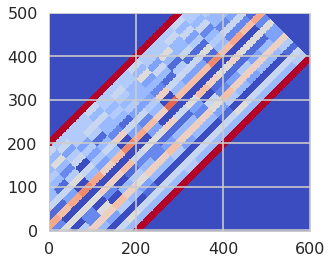

In [134]:
values[np.isnan(values)] = 0
if ellipse_pars is None:
    a = 350
    b = 150
    x = 250
    y = 250

    theta = 45. / 180 * np.pi

else:
    a, b, x, y, theta = ellipse_pars

A = a**2 * (np.sin(theta))**2 + b**2 * (np.cos(theta))**2
B = 2 * (b**2 - a**2) * np.sin(theta) * np.cos(theta)
C = a**2 * np.cos(theta)**2 + b**2 * np.sin(theta)**2
D = -2 * A * x - B* y
E = -B * x - 2 * C * y
F = A* x**2 + B*x*y + C*y**2 - a**2*b**2

X,Y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))

in_ellipse = A*X**2 + B*X*Y +C*Y**2 + D*X + E*Y +F < 0
in_ellipse = np.ones_like(in_ellipse, dtype=bool)
pc1 = np.array([[np.cos(theta)], [np.sin(theta)]])
pc2 = np.array([[np.cos(theta - np.pi/2.)], [np.sin(theta - np.pi/2.)]])

pc1_distance = pc1.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)
pc2_distance = pc2.T.dot(np.array([(X - x).ravel(), (Y - y).ravel()])).reshape(X.shape)

pc1_quantile = np.floor((pc1_distance / a + 1 ) / 2. * values.shape[0])
pc2_quantile = np.floor((pc2_distance / b + 1 ) / 2. * values.shape[1])

im = np.zeros_like(X, dtype=float)

for pc1_q in np.arange(values.shape[0]):
    for pc2_q in np.arange(values.shape[1]):
        im[in_ellipse * (pc1_quantile == pc1_q) & (pc2_quantile == pc2_q)] = values[pc1_q, pc2_q]

im = np.ma.masked_array(im, ~in_ellipse)
#     cmap.set_bad('grey')
if ax is None:
    cax = plt.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)#, **kwargs)
else:
    ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)#, **kwargs)
    cax = ax